# Bayes Nets
** A Julia package for Bayesian Networks **

A Bayesian Network (BN) represents a probability distribution over a set of variables, $P(x_1, x_2, \ldots, x_n)$. Bayesian networks leverage variable relations in order to efficiently decompose the joint distribution into smaller conditional probability distributions.

A BN is defined by a directed acyclic graph and a set of conditional probability distributions. Each node in the graph corresponds to a variable $x_i$ and is associated with a conditional probability distribution $P(x_i \mid \text{parents}(x_i))$.

## Installation

`Pkg.add("BayesNets");`

Visualization of network structure is provided by the TikzGraphs package. Installation requirements (e.g., PGF/Tikz and pdf2svg) are provided [here](http://nbviewer.ipython.org/github/sisl/TikzGraphs.jl/blob/master/doc/TikzGraphs.ipynb).

## Usage

In [ ]:
using Random
Random.seed!(0) # seed the random number generator to 0, for a reproducible demonstration
using BayesNets

## Representation

Bayesian Networks are represented with the `BayesNet` type. This type contains the directed acyclic graph (a LightTables.DiGraph) and a list of conditional probability distributions (a list of CPDs)

Here we construct the BayesNet $a \rightarrow b$, with Gaussians $a$ and $b$:

$$
a = \mathcal{N}(0,1) \qquad b = \mathcal{N}(2a +3,1)
$$

In [2]:
bn = BayesNet()
push!(bn, StaticCPD(:a, Normal(1.0)))
push!(bn, LinearGaussianCPD(:b, [:a], [2.0], 3.0, 1.0))

## Conditional Probability Distributions

Conditional Probablity Distributions, $P(x_i \mid \text{parents}(x_i))$, are defined in BayesNets.CPDs. Each CPD knows its own name, the names of its parents, and is associated with a distribution from Distributions.jl.

| `CPDForm`                      | Description |
| ------------------------------ | ----------- |
| `StaticCPD`                    | Any `Distributions.distribution`; indepedent of any parents |
| `FunctionalCPD`                | Allows for a CPD defined with a custom eval function |
| `ParentFunctionalCPD`          | Modification to `FunctionalCPD` allowing the parent values to be passed in |
| `CategoricalCPD`               | Categorical distribution, assumes integer parents in $1:N$ |
| `LinearGaussianCPD`            | Linear Gaussian, assumes target and parents are numeric |
| `ConditionalLinearGaussianCPD` | A linear Gaussian for each discrete parent instantiation|

Each CPD can be learned from data using `fit`.

Here we learn the same network as above.

In [3]:
a = randn(100)
b = randn(100) .+ 2*a .+ 3

data = DataFrame(a=a, b=b)
cpdA = fit(StaticCPD{Normal}, data, :a)
cpdB = fit(LinearGaussianCPD, data, :b, [:a])

bn2 = BayesNet([cpdA, cpdB])

Each `CPD` implements four functions:

* `name(cpd)` - obtain the name of the variable target variable
* `parents(cpd)` - obtain the list of parents
* `nparams(cpd` - obtain the number of free parameters in the CPD
* `cpd(assignment)` - allows calling `cpd()` to obtain the conditional distribution
* `Distributions.fit(Type{CPD}, data, target, parents)`

In [4]:
cpdB(:a=>0.5)

Distributions.Normal{Float64}(μ=3.7835395874388134, σ=2.236109637835203)

Several functions conveniently condition and then produce their return values:

In [5]:
rand(cpdB, :a=>0.5) # condition and then sample
pdf(cpdB, :a=>1.0, :b=>3.0) # condition and then compute pdf(distribution, 3)
logpdf(cpdB, :a=>1.0, :b=>3.0) # condition and then compute logpdf(distribution, 3);

The NamedCategorical distribution allows for String or Symbol return values.
The FunctionalCPD allows for crafting quick and simple CPDs:

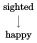

In [6]:
bn2 = BayesNet()
push!(bn2, StaticCPD(:sighted, NamedCategorical([:bird, :plane, :superman], [0.40, 0.55, 0.05])))
push!(bn2, FunctionalCPD{Bernoulli}(:happy, [:sighted], a->Bernoulli(a == :superman ? 0.95 : 0.2)))

Variables can be removed by name using `delete!`. A warning will be issued when removing a CPD with children.

In [7]:
delete!(bn2, :happy)

## Likelihood 

A Bayesian Network represents a joint probability distribution, $P(x_1, x_2, \ldots, x_n)$. 
Assignments are represented as dictionaries mapping variable names (Symbols) to variable values.
We can evaluate probabilities as we would with Distributions.jl, only we use exclamation points as we modify the internal state when we condition:

In [8]:
pdf(bn, :a=>0.5, :b=>2.0) # evaluate the probability density

0.01900834726778591

We can also evaluate the likelihood of a dataset:

In [9]:
data = DataFrame(a=[0.5,1.0,2.0], b=[4.0,5.0,7.0])
pdf(bn, data)    #  0.00215
logpdf(bn, data) # -6.1386;

Or the likelihood for a particular cpd:

In [10]:
pdf(cpdB, data)    #  0.006
logpdf(cpdB, data) # -5.201

-5.200981176187056

## Sampling

Assignments can be sampled from a `BayesNet`.

In [11]:
rand(bn)

Dict{Symbol,Any} with 2 entries:
  :a => 1.06468
  :b => 6.03699

In [12]:
rand(bn, 5)

,a,b
1,0.7623039965961161,3.4917223005147227
2,-0.8005501733900879,0.23443764725795835
3,2.2115810954933637,7.515865521050183
4,-0.27359849027000194,3.7133964333979224
5,-0.42515634692622406,2.4710294668620785


In general, sampling can be done according to `rand(BayesNet, BayesNetSampler, nsamples)` to produce a table of samples, `rand(BayesNet, BayesNetSampler)` to produce a single Assignment, or `rand!(Assignment, BayesNet, BayesNetSampler)` to modify an assignment in-place.

New samplers need only implement `rand!`.

The functions above default to the `DirectSampler`, which samples the variables in topographical order.

Rejection sampling can be used to draw samples that are consistent with a provided assignment:

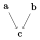

In [13]:
bn = BayesNet()
push!(bn, StaticCPD(:a, Categorical([0.3,0.7])))
push!(bn, StaticCPD(:b, Categorical([0.6,0.4])))
push!(bn, CategoricalCPD{Bernoulli}(:c, [:a, :b], [2,2], [Bernoulli(0.1), Bernoulli(0.2), Bernoulli(1.0), Bernoulli(0.4)]))

In [14]:
rand(bn, RejectionSampler(:c=>1), 5)

,a,b,c
1,2,2,1
2,2,1,1
3,2,1,1
4,2,1,1
5,2,2,1


One can also use weighted sampling:

In [15]:
rand(bn, LikelihoodWeightedSampler(:c=>1), 5)

,a,b,c,p
1,1,1,1,0.09090909090909091
2,2,1,1,0.18181818181818182
3,2,1,1,0.18181818181818182
4,2,2,1,0.36363636363636365
5,2,1,1,0.18181818181818182


One can also use Gibbs sampling.  More options are available than are shown in the example below.

In [16]:
bn_gibbs = BayesNet()
push!(bn_gibbs, StaticCPD(:a, Categorical([0.999,0.001])))
push!(bn_gibbs, StaticCPD(:b, Normal(1.0)))
push!(bn_gibbs, LinearGaussianCPD(:c, [:a, :b], [3.0, 1.0], 0.0, 1.0))

evidence = Assignment(:c => 10.0)
initial_sample = Assignment(:a => 1, :b => 1, :c => 10.0)
gsampler = GibbsSampler(evidence, burn_in=500, thinning=1, initial_sample=initial_sample)
rand(bn_gibbs, gsampler, 5)

,a,b,c
1,1,9.240652298406218,10.0
2,1,6.037264154687797,10.0
3,1,6.841756268244145,10.0
4,1,9.50983660700297,10.0
5,1,8.568531949095366,10.0


## Parameter Learning

BayesNets.jl supports parameter learning for an entire graph.

In [17]:
# specify each node's CPD type individually
fit(BayesNet, data, (:a=>:b), [StaticCPD{Normal}, LinearGaussianCPD])

In [18]:
# specify a single CPD type for all nodes
fit(BayesNet, data, (:a=>:b), LinearGaussianCPD)

Fitting can be done for specific BayesNets types as well:

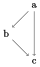

In [19]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])

fit(DiscreteBayesNet, data, (:a=>:b, :a=>:c, :b=>:c))

Fitting a `DiscreteCPD`, which is a `CategoricalCPD{Categorical}`, can be done with a specified number of categories. This prevents cases where your test data does not provide an example for every category.

In [20]:
cpd = fit(DiscreteCPD, DataFrame(a=[1,2,1,2,2]), :a, ncategories=3);
cpd = fit(DiscreteCPD, data, :b, [:a], parental_ncategories=[3], target_ncategories=3);

## Inference

Inference methods for discrete Bayesian networks can be used via the `infer` method:

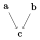

In [21]:
bn = DiscreteBayesNet()
push!(bn, DiscreteCPD(:a, [0.3,0.7]))
push!(bn, DiscreteCPD(:b, [0.2,0.8]))
push!(bn, DiscreteCPD(:c, [:a, :b], [2,2], 
        [Categorical([0.1,0.9]),
         Categorical([0.2,0.8]),
         Categorical([1.0,0.0]),
         Categorical([0.4,0.6]),
        ]))

In [22]:
ϕ = infer(bn, :c, evidence=Assignment(:b=>1))

,c,potential
1,1,0.16999999999999996
2,2,0.83


Several inference methods are available. Exact inference is the default.

| `InfereceMethod`               | Description |
| ------------------------------ | ----------- |
| `ExactInference`               | Performs exact inference using discrete factors and variable elimination |
| `LikelihoodWeightingInference` | Approximates p(query \ evidence) with N weighted samples using likelihood weighted sampling |
| `LoopyBelief`                  | The loopy belief propagation algorithm |
| `GibbsSamplingNodewise`        | Gibbs sampling where each iteration changes one node |
| `GibbsSamplingFull`            | Gibbs sampling where each iteration changes all nodes | 

All inference methods inherit from the `InferenceMethod` type.

In [23]:
ϕ = infer(GibbsSamplingNodewise(), bn, [:a, :b], evidence=Assignment(:c=>2))

,a,b,potential
1,1,1,0.13
2,2,1,0.224
3,1,2,0.0
4,2,2,0.646


Inference produces a `Factor` type. It can be converted to a DataFrame.

In [24]:
convert(DataFrame, ϕ)

,a,b,potential
1,1,1,0.13
2,2,1,0.224
3,1,2,0.0
4,2,2,0.646


## Structure Learning

Structure learning can be done as well.

In [25]:
using Discretizers
using RDatasets
iris = dataset("datasets", "iris")
names(iris)
data = DataFrame(
    SepalLength = iris[:SepalLength],
    SepalWidth = iris[:SepalWidth],
    PetalLength = iris[:PetalLength],
    PetalWidth = iris[:PetalWidth],
    Species = encode(CategoricalDiscretizer(iris[:Species]), iris[:Species]),
)
data[1:3,:] # only display a subset...

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
1,5.1,3.5,1.4,0.2,1
2,4.9,3.0,1.4,0.2,1
3,4.7,3.2,1.3,0.2,1


Here we use the K2 structure learning algorithm which runs in polynomial time but requires that we specify a topological node ordering.

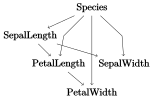

In [26]:
parameters = K2GraphSearch([:Species, :SepalLength, :SepalWidth, :PetalLength, :PetalWidth], 
                       ConditionalLinearGaussianCPD,
                       max_n_parents=2)
fit(BayesNet, data, parameters)

CPD types can also be specified per-node. Note that complete CPD definitions are required - simply using `StaticCPD` is insufficient as you need the target distribution type as well, as in `StaticCPD{Categorical}`.

Changing the ordering will change the structure.

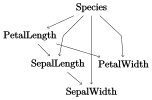

In [27]:
CLG = ConditionalLinearGaussianCPD
parameters = K2GraphSearch([:Species, :PetalLength, :PetalWidth, :SepalLength, :SepalWidth], 
                        [StaticCPD{Categorical}, CLG, CLG, CLG, CLG],
                        max_n_parents=2)
fit(BayesNet, data, parameters)

A `ScoringFunction` allows for extracting a scoring metric for a CPD given data.
The negative BIC score is implemented in NegativeBayesianInformationCriterion.

A `GraphSearchStrategy` defines a structure learning algorithm.
The K2 algorithm is defined through `K2GraphSearch` and `GreedyHillClimbing` is implemented for discrete Bayesian networks and the Bayesian score:

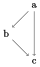

In [28]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])
parameters = GreedyHillClimbing(ScoreComponentCache(data), max_n_parents=3, prior=UniformPrior())
bn = fit(DiscreteBayesNet, data, parameters)

One can specify the number of categories for each variable in case it cannot be correctly inferred:

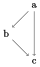

In [29]:
bn = fit(DiscreteBayesNet, data, parameters, ncategories=[3,3,2])

A whole suite of features are supported for DiscreteBayesNets.

In [30]:
bayesian_score(bn, data, parameters.prior) # compute the Bayesian score of the data under the BayesNet

-31.28804624550449

In [31]:
count(bn, :a, data) # obtain a list of counts for the node

,a,count
1,1,9
2,2,3


In [32]:
statistics(bn.dag, data) # sufficient statistics from a discrete dataset

3-element Array{Array{Int64,2},1}:
 [4; 4; 4]             
 [3 1 3; 1 3 1]        
 [3 1 … 2 0; 0 0 … 1 1]

In [33]:
table(bn, :b) # obtain the factor table for a node

,a,b,p
1,1,1,0.6666666666666666
2,2,1,0.16666666666666666
3,1,2,0.25
4,2,2,0.6666666666666666
5,1,3,0.08333333333333333
6,2,3,0.16666666666666666


In [34]:
table(bn, :c, :a=>1) # obtain a factor table matching a particular assignment

,b,a,c,p
1,1,1,1,0.4
2,2,1,1,0.2
3,3,1,1,0.3333333333333333
4,1,1,2,0.2
5,2,1,2,0.6
6,3,1,2,0.3333333333333333
7,1,1,3,0.4
8,2,1,3,0.2
9,3,1,3,0.3333333333333333


# Reading from XDSL

One can read discrete Bayesian networks from the .XDSL file format.

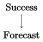

In [35]:
bn = readxdsl(joinpath(dirname(pathof(BayesNets)), "..", "test", "sample_bn.xdsl"))

# Bayesian Score for a Network Structure

The bayesian score for a discrete-valued BayesNet can can be calculated based only on the structure and data (the CPDs do not need to be defined beforehand). This is implemented with a method of `bayesian_score` that takes in a directed graph, the names of the nodes and data.

In [36]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])
g = DAG(3)
add_edge!(g,1,2); add_edge!(g,2,3); add_edge!(g,1,3)
bayesian_score(g, [:a,:b,:c], data)

-29.642240688899513